In [40]:
import matplotlib.pyplot as plt

print("Begin init")
%run -i notebook/init_notebook.ipynb


import pandas as pd
import numpy as np

from structlog import get_logger
from tqdm import tqdm


from lib.model.StockModel import StockModel
from lib.repository.FileOhlcRepository import FileOhlcRepository
from lib.repository.SymbolRepository import SymbolRepository
from lib.scrapper.YahooScrapper import YahooScrapper
from datetime import datetime, timedelta
print("Loading modules complete", datetime.now())

Begin init
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading modules complete 2021-05-06 09:37:27.762456


In [41]:
def _get_1min_data(symbol):
    from structlog import get_logger
    logger = get_logger()
    stop_date = datetime.utcnow()
    start_date = stop_date - timedelta(days=365)
    ohlc_repository = FileOhlcRepository("./_data/", logger)
    df_original = ohlc_repository.read_data("yahoo", symbol, start_date, stop_date)

    df_original = df_original[df_original['volume'] > 0]
    return df_original


stock = StockModel.parse("NASDAQ:MSFT")
min1_df = _get_1min_data(stock)
min1_df.describe()

,low,close,open,high,volume
count,75406.000000,75406.000000,75406.000000,75406.000000,7.540600e+04
mean,222.795352,222.898161,222.898428,222.999701,3.104025e+09
std,15.830188,15.823068,15.822772,15.815738,8.562049e+10
min,196.380000,196.470000,196.455000,196.670000,1.420000e+02
25%,210.921250,211.045250,211.050000,211.150000,3.107000e+04
50%,216.920000,217.029500,217.030000,217.125000,4.727600e+04
75%,233.731500,233.850000,233.860000,233.960000,7.585350e+04
max,262.950000,263.180000,263.190000,263.190000,5.425764e+12


BB_STDDEV(col:'close', n:14)


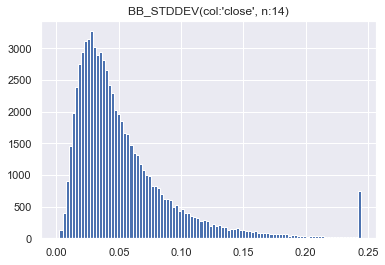

Min:1.1638178938488146e-05
Max:0.24434221952961288

75% 0.06633525343561383
80% 0.07468274247041888
90% 0.2433232184816691
99% 0.2433232184816691
********************************************************************************************************************************************************************************************************
BB_%(col:'close', n:14)


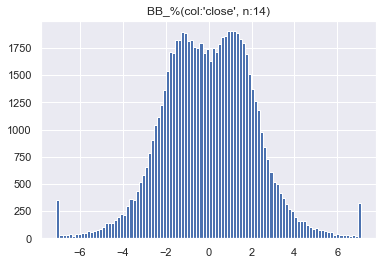

Min:-7.093868350015512
Max:7.093868350015512

75% 2.2724014197893623
80% 2.505291792263321
90% 6.789420769891601
99% 6.789420769891601
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:14)_logroc(2)


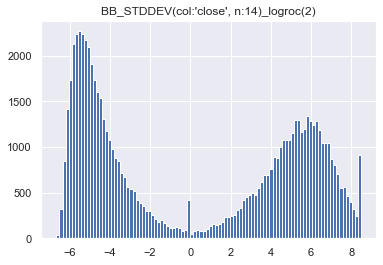

Min:-6.66
Max:8.48

75% 5.9
80% 6.09
90% 8.47
99% 8.47
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:14)_logroc(2)


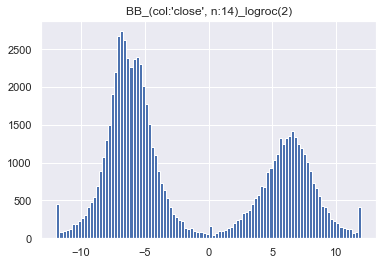

Min:-11.92
Max:11.92

75% 7.43
80% 7.72
90% 11.92
99% 11.92
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:14)_logroc(5)


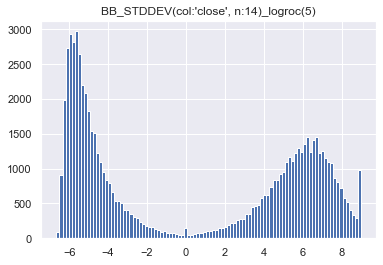

Min:-6.66
Max:8.98

75% 6.25
80% 6.45
90% 8.98
99% 8.98
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:14)_logroc(5)


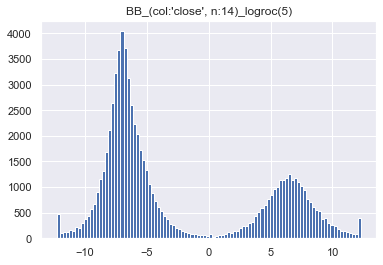

Min:-12.299499999999972
Max:12.299499999999972

75% 7.79
80% 8.08
90% 12.299499999999972
99% 12.299499999999972
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:14)_logroc(10)


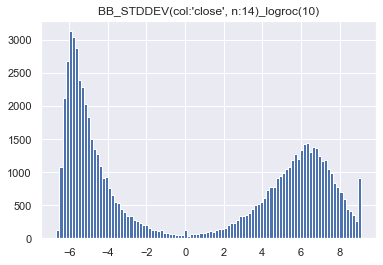

Min:-6.66
Max:9.09

75% 6.27
80% 6.48
90% 9.08
99% 9.08
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:14)_logroc(10)


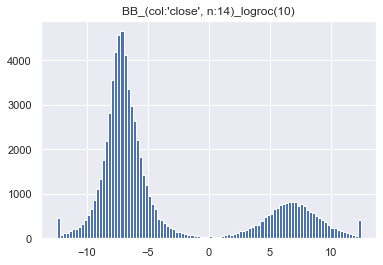

Min:-12.47
Max:12.47

75% 8.04
80% 8.31
90% 12.47
99% 12.47
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:24)


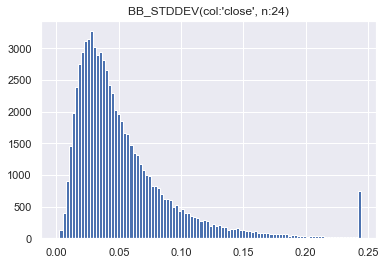

Min:1.1638178938488146e-05
Max:0.24434221952961288

75% 0.06633525343561383
80% 0.07468274247041888
90% 0.2433232184816691
99% 0.2433232184816691
********************************************************************************************************************************************************************************************************
BB_%(col:'close', n:24)


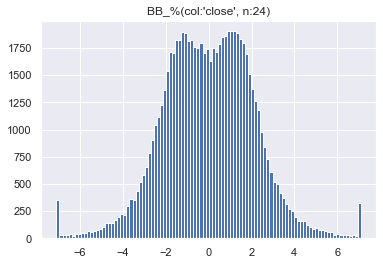

Min:-7.093868350015512
Max:7.093868350015512

75% 2.2724014197893623
80% 2.505291792263321
90% 6.789420769891601
99% 6.789420769891601
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:24)_logroc(2)


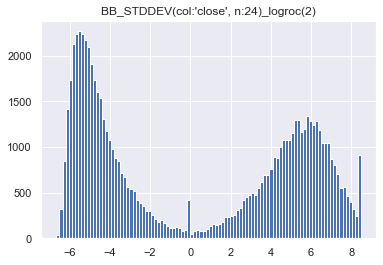

Min:-6.66
Max:8.48

75% 5.9
80% 6.09
90% 8.47
99% 8.47
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:24)_logroc(2)


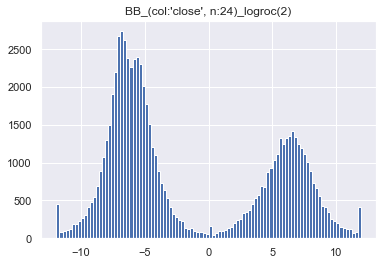

Min:-11.92
Max:11.92

75% 7.43
80% 7.72
90% 11.92
99% 11.92
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:24)_logroc(5)


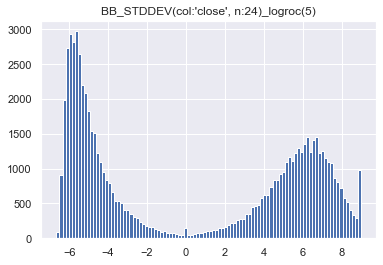

Min:-6.66
Max:8.98

75% 6.25
80% 6.45
90% 8.98
99% 8.98
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:24)_logroc(5)


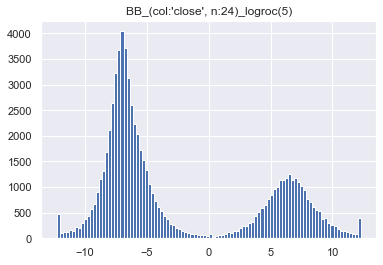

Min:-12.299499999999972
Max:12.299499999999972

75% 7.79
80% 8.08
90% 12.299499999999972
99% 12.299499999999972
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:24)_logroc(10)


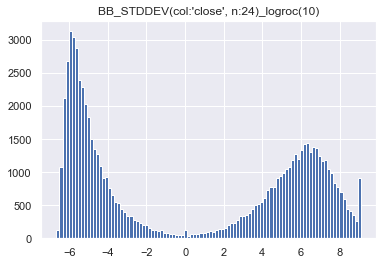

Min:-6.66
Max:9.09

75% 6.27
80% 6.48
90% 9.08
99% 9.08
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:24)_logroc(10)


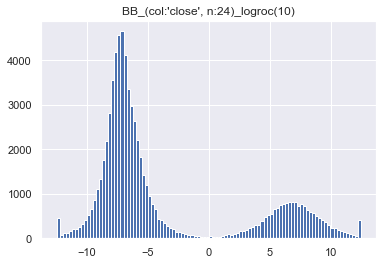

Min:-12.47
Max:12.47

75% 8.04
80% 8.31
90% 12.47
99% 12.47
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:32)


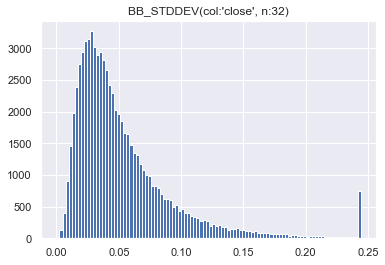

Min:1.1638178938488146e-05
Max:0.24434221952961288

75% 0.06633525343561383
80% 0.07468274247041888
90% 0.2433232184816691
99% 0.2433232184816691
********************************************************************************************************************************************************************************************************
BB_%(col:'close', n:32)


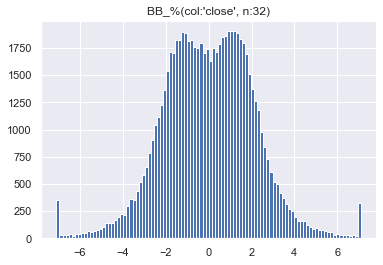

Min:-7.093868350015512
Max:7.093868350015512

75% 2.2724014197893623
80% 2.505291792263321
90% 6.789420769891601
99% 6.789420769891601
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:32)_logroc(2)


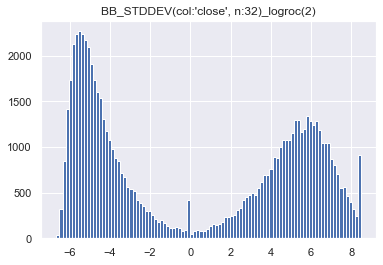

Min:-6.66
Max:8.48

75% 5.9
80% 6.09
90% 8.47
99% 8.47
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:32)_logroc(2)


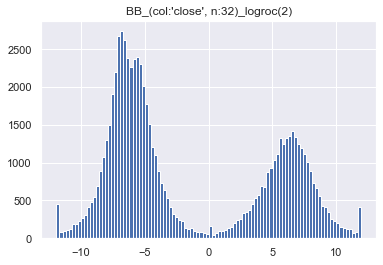

Min:-11.92
Max:11.92

75% 7.43
80% 7.72
90% 11.92
99% 11.92
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:32)_logroc(5)


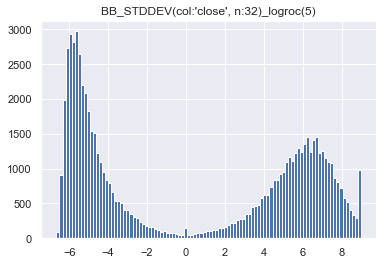

Min:-6.66
Max:8.98

75% 6.25
80% 6.45
90% 8.98
99% 8.98
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:32)_logroc(5)


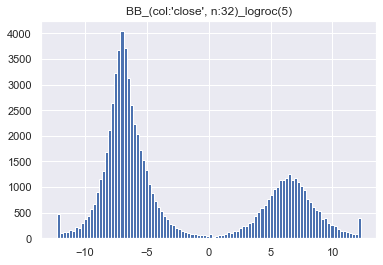

Min:-12.299499999999972
Max:12.299499999999972

75% 7.79
80% 8.08
90% 12.299499999999972
99% 12.299499999999972
********************************************************************************************************************************************************************************************************
BB_STDDEV(col:'close', n:32)_logroc(10)


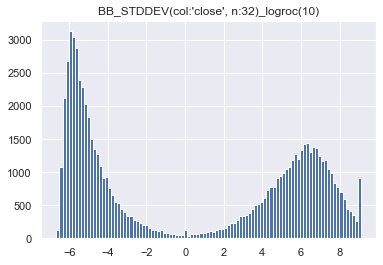

Min:-6.66
Max:9.09

75% 6.27
80% 6.48
90% 9.08
99% 9.08
********************************************************************************************************************************************************************************************************
BB_(col:'close', n:32)_logroc(10)


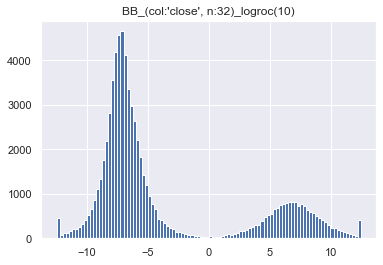

Min:-12.47
Max:12.47

75% 8.04
80% 8.31
90% 12.47
99% 12.47
********************************************************************************************************************************************************************************************************


In [152]:
from lib.calulation.BollingerBand import BollingerBand
from lib.calulation.PpoBuilder import PpoBuilder
import lib.calulation.utils as ta_utils

from lib.calulation.indicator_builder import build_indicatrors

rocs = [2, 5, 10] # 2, 5, 10
property = 'close'
indicators = [
    # ta.VortexBuilder(14, rocs=rocs),
    # ta.VortexBuilder(24, rocs=rocs),
    # ta.VortexBuilder(32, rocs=rocs),
    #
    # ta.RsiBuilder(14, 8,  rocs=rocs),
    # ta.RsiBuilder(24, 8,  rocs=rocs),
    # ta.RsiBuilder(32, 8,  rocs=rocs),`


    # BollingerBand(property=property, n=14, rocs=rocs),
    # BollingerBand(property=property, n=24, rocs=rocs),
    # BollingerBand(property=property, n=32, rocs=rocs),

    #PpoBuilder(slow=30, fast=10, smooth=5, rocs=rocs)
]

df = min1_df.copy()
""
basic_price = df.iloc[0].low
basic_volume = df.volume.min()
ta_utils.normilize_data_(df, basic_price, basic_volume)


min1_df_with_indicators = build_indicatrors(df, indicators)
min1_df_with_indicators = min1_df_with_indicators.iloc[2000:-1] # drop warmup

# print(min1_df_with_indicators.iloc[-1].to_dict())
raw_columns = {'date', 'low', 'close', 'high', 'open', 'volume'}
for col in min1_df_with_indicators.columns:
    if col in raw_columns:
        continue

    print(f"{col}")
    plt.title(col)
    min1_df_with_indicators[col].hist(bins=100)
    plt.show()
    print(f"Min:{min1_df_with_indicators[col].min()}")
    print(f"Max:{min1_df_with_indicators[col].max()}")
    abs = np.abs(min1_df_with_indicators[col])
    print()
    print("75%", np.percentile(abs, 75))
    print("80%", np.percentile(abs, 80))
    print("90%", np.percentile(abs, 99))
    print("99%", np.percentile(abs, 99))
    print("*"*200)


